# Dataset MVTec

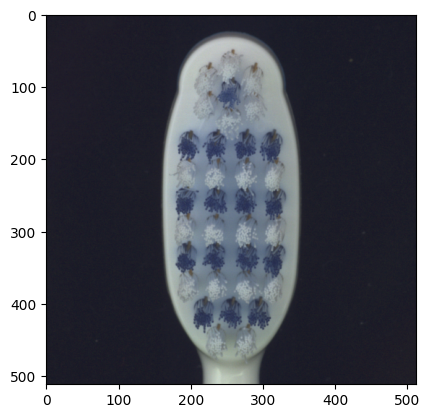

In [27]:
import matplotlib.pyplot as plt
from src.data_loader.data_loader import MVTec

dataset_root_path = "/home/evry/Desktop/master-degree/repositories/two-stage-coarse-to-fine-image-anomaly-segmentation-and-detection-model/data/images"

class_name = "toothbrush"

train_dataset = MVTec(class_name, dataset_root_path + f"/{class_name}", test=False)
test_dataset = MVTec(class_name, dataset_root_path + f"/{class_name}", test=True)

plt.imshow(train_dataset.__getitem__(0)[0].cpu().numpy().transpose(1, 2, 0))

In [2]:
train_loader, test_loader = read_data('carpet')

image = train_loader.dataset.__getitem__(0)[0]

# padding = (16, 16, 16, 16)

# # Add padding to the image
# padded_image = F.pad(image, padding, mode='constant', value=0)

# resized_image = F.interpolate(padded_image.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)
# print(resized_image.shape)
plt.imshow(image.cpu().numpy().transpose(1, 2, 0))

NameError: name 'read_data' is not defined

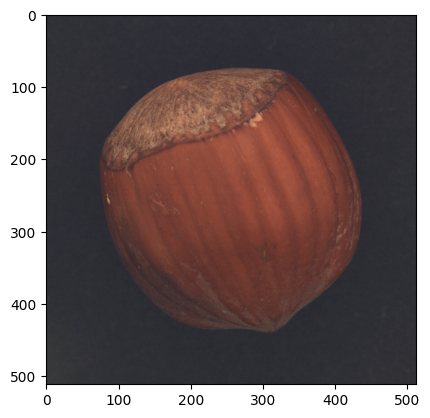

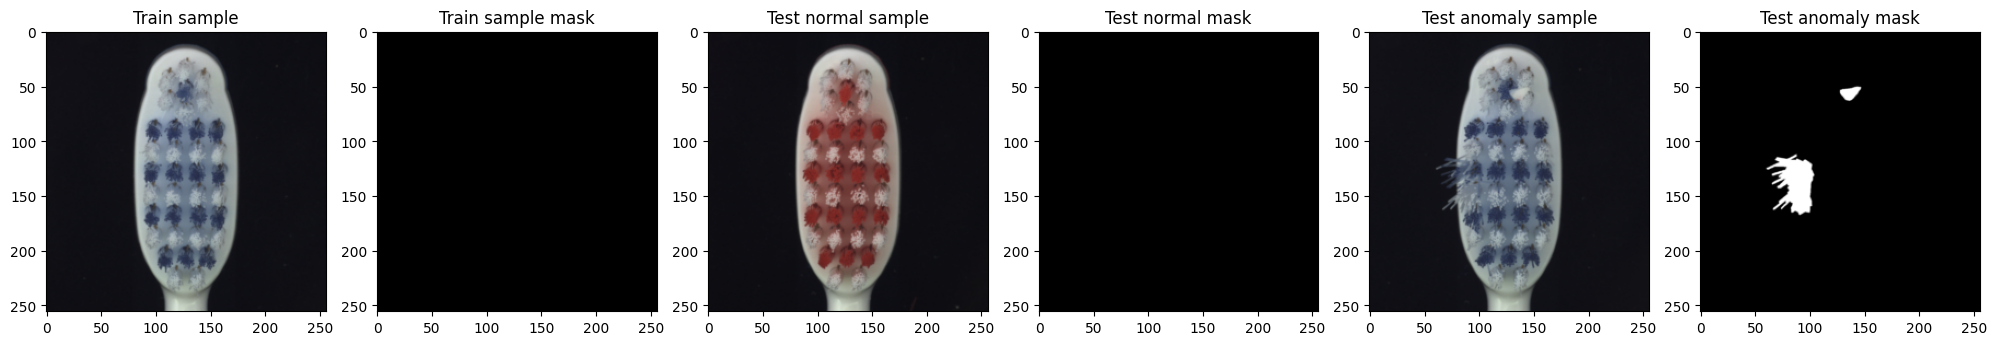

In [11]:
train_image, train_mask = train_dataset.__getitem__(0)
test_normal_image, test_normal_mask = test_dataset.__getitem__(35)
test_anomaly_image, test_anomaly_mask = test_dataset.__getitem__(0)


fig = plt.figure(figsize=(20, 5))

# Adding subplots
ax1 = fig.add_subplot(161)
ax1.imshow(train_image.numpy().transpose(1, 2, 0))
ax1.set_title('Train sample')

ax2 = fig.add_subplot(162)
ax2.imshow(train_mask.numpy().transpose(1, 2, 0))
ax2.set_title('Train sample mask')

ax2 = fig.add_subplot(163)
ax2.imshow(test_normal_image.numpy().transpose(1, 2, 0))
ax2.set_title('Test normal sample')

ax3 = fig.add_subplot(164)
ax3.imshow(test_normal_mask.numpy().transpose(1, 2, 0))
ax3.set_title('Test normal mask')

ax4 = fig.add_subplot(165)
ax4.imshow(test_anomaly_image.numpy().transpose(1, 2, 0))
ax4.set_title('Test anomaly sample')

ax5 = fig.add_subplot(166)
ax5.imshow(test_anomaly_mask.numpy().transpose(1, 2, 0))
ax5.set_title('Test anomaly mask')

plt.tight_layout()

plt.show()

# Vision Transformer

In [5]:
from src.model.vit import ViT
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

device = 'cuda'

model = ViT(
    dim=512,
    image_size=512,
    patch_size=32,
    num_classes=1,
    channels=3,
    depth = 6,
    heads = 8,
    mlp_dim = 1024
).to(device)

_ = model.train()

In [6]:
summary(model, (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 512]             --
|    └─Rearrange: 2-1                    [-1, 64, 3072]            --
|    └─LayerNorm: 2-2                    [-1, 64, 3072]            6,144
|    └─Linear: 2-3                       [-1, 64, 512]             1,573,376
|    └─LayerNorm: 2-4                    [-1, 64, 512]             1,024
├─Dropout: 1-2                           [-1, 65, 512]             --
├─Transformer: 1-3                       [-1, 65, 512]             --
|    └─LayerNorm: 2-5                    [-1, 65, 512]             1,024
├─Identity: 1-4                          [-1, 512]                 --
├─Linear: 1-5                            [-1, 1]                   513
Total params: 1,582,081
Trainable params: 1,582,081
Non-trainable params: 0
Total mult-adds (M): 28.33
Input size (MB): 0.75
Forward/backward pass size (MB): 2.25
Params size (MB): 6.04
Estimated Total Size (

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 512]             --
|    └─Rearrange: 2-1                    [-1, 64, 3072]            --
|    └─LayerNorm: 2-2                    [-1, 64, 3072]            6,144
|    └─Linear: 2-3                       [-1, 64, 512]             1,573,376
|    └─LayerNorm: 2-4                    [-1, 64, 512]             1,024
├─Dropout: 1-2                           [-1, 65, 512]             --
├─Transformer: 1-3                       [-1, 65, 512]             --
|    └─LayerNorm: 2-5                    [-1, 65, 512]             1,024
├─Identity: 1-4                          [-1, 512]                 --
├─Linear: 1-5                            [-1, 1]                   513
Total params: 1,582,081
Trainable params: 1,582,081
Non-trainable params: 0
Total mult-adds (M): 28.33
Input size (MB): 0.75
Forward/backward pass size (MB): 2.25
Params size (MB): 6.04
Estimated Total Size (

In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=True)

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch

In [15]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)

for epoch in range(5):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        
        print(f"Input shape: {data.shape} - Output shape: {output.shape}")
        
        loss = F.mse_loss(output,data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        # epoch_accuracy += acc / len(train_loader)
        # epoch_loss += loss / len(train_loader)

    # with torch.no_grad():
    #     epoch_val_accuracy = 0
    #     epoch_val_loss = 0
    #     for data, label in valid_loader:
    #         data = data.to(device)
    #         label = label.to(device)

    #         val_output = model(data)
    #         val_loss = criterion(val_output, label)

    #         acc = (val_output.argmax(dim=1) == label).float().mean()
    #         epoch_val_accuracy += acc / len(valid_loader)
    #         epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f}\n"
    )

Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])


/tmp/ipykernel_29233/422850073.py:18: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output,data)


Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])
Input shape: torch.Size([1, 3, 256, 256]) - Output shape: torch.Size([1, 1])

KeyboardInterrupt: 

# Tasad

In [2]:
%cd src

/home/evry/Desktop/master-degree/repositories/vision-anomaly/src


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from tasad.tasad_model import TasadModel
from torchsummary import summary

In [5]:
tasad       = TasadModel(in_channels=3, out_channels=1)
params_tasad         = TasadModel.get_n_params(tasad)

print("Tasad params", params_tasad)

print(summary(tasad, (3, 256, 256)))

Tasad params 11959681


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 512, 64, 64]         --
|    └─Sequential: 2-1                   [-1, 128, 256, 256]       --
|    |    └─Conv2d: 3-1                  [-1, 128, 256, 256]       3,584
|    |    └─BatchNorm2d: 3-2             [-1, 128, 256, 256]       256
|    |    └─ReLU: 3-3                    [-1, 128, 256, 256]       --
|    |    └─Conv2d: 3-4                  [-1, 128, 256, 256]       147,584
|    |    └─BatchNorm2d: 3-5             [-1, 128, 256, 256]       256
|    |    └─ReLU: 3-6                    [-1, 128, 256, 256]       --
|    └─MaxPool2d: 2-2                    [-1, 128, 128, 128]       --
|    └─Sequential: 2-3                   [-1, 256, 128, 128]       --
|    |    └─Conv2d: 3-7                  [-1, 256, 128, 128]       295,168
|    |    └─BatchNorm2d: 3-8             [-1, 256, 128, 128]       512
|    |    └─ReLU: 3-9                    [-1, 256, 128, 128]       --